In [1]:
import sys
# sys.path.append('G:/My Drive/Research/adaptation_abm/code')
sys.path.append('/home/twilliams/adaptation_abm/code')
import model.model as mod_code
import plot.single_run as plt_single
import imp
import importlib
import numpy as np
import pandas as pd
import pickle
import copy
imp.reload(mod_code)
import matplotlib.pyplot as plt
import model.base_inputs as base_inputs
import experiments.POM as POM
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import matplotlib.transforms as transforms

### Input parameters

In [2]:
# POM
f = '../../outputs/2020_2_5_10/POM/200000_20reps/input_params_0.pkl'
inputs_pom = pickle.load(open(f, 'rb'))
# params not in POM
inputs = base_inputs.compile()
for k, v in inputs_pom.items():
    for k2, v2 in v.items():
        inputs[k][k2] = v2
inputs['agents']['file_name'] = '../../inputs/lsla_for_abm.csv'

### Define scenarios

In [3]:
inputs['model']['T'] = 30
inputs['model']['n_agents'] = 40

In [4]:
scenarios = {
    'baseline' : {'model' : {'lsla_simulation' : False}},
    'LSLA' : {'model' : {'lsla_simulation' : True},
             'LSLA' : {
        'tstart' : 5, # e.g. 5 means start of 6th year of simulation
        'size' : 0.25, # ha per agent
        'employment' : 2, # jobs/ha taken
        'LUC' : 'farm', # 'farm' or 'commons'' or ?'none'?
        'encroachment' : 'farm', # where do displaced HHs encroach on? 'farm' or 'commons'
        'frac_retain' : 0.5, # fraction of land that was originally taken that HHs retain (on average)
        'land_distribution_type' : 'amt_lost', # amt_lost: proportional to the amt of land lost, 'equal_hh' : equal per hh, "equal_pp" : equal per person
        'land_taking_type' : 'equalizing', # random or equalizing
        }},
}

### Run the model

In [49]:
mods = {}
for name, vals in scenarios.items():
    # change the params
    params = copy.copy(inputs)
    for k, v in vals.items():
        for k2, v2 in v.items():
            params[k][k2] = v2
    
    # initialize and run model
    m = mod_code.Model(params)
    for t in range(m.T):
        m.step()
    mods[name] = m

2020_2_5_10/POM/200000_20reps/0/
2020_2_5_10/POM/200000_20reps/0/


# Plotting

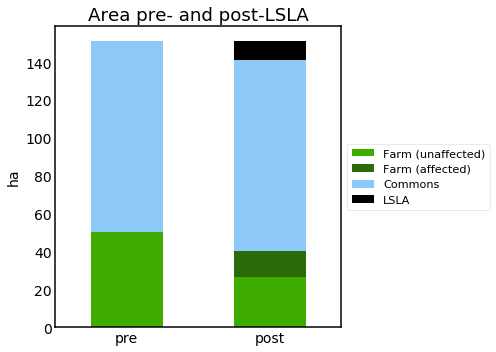

In [6]:
## land composition before and after
fig, ax = plt.subplots(1,1,figsize=(7,5))
farm_pre = mods['baseline'].land.tot_area
common_pre = mods['baseline'].rangeland.size_ha

farm_unaffected_post = mods['LSLA'].agents.land_area[~mods['LSLA'].lsla.lost_land].sum()
farm_affected_post = mods['LSLA'].agents.land_area[mods['LSLA'].lsla.lost_land].sum()
common_post = mods['LSLA'].rangeland.size_ha
lsla_post = mods['LSLA'].lsla.area

df = pd.DataFrame({'Farm (unaffected)' : [farm_pre,farm_unaffected_post],
                  'Farm (affected)' : [0, farm_affected_post],
                  'Commons' : [common_pre,common_post],
                  'LSLA' : [0,lsla_post]}, index=['pre','post'])
df.plot.bar(rot=0, ax=ax, stacked=True, color=['#3FAC00','#2C6908','#8DC8F6','#000000'])
ax.grid(False)
ax.set_ylabel('ha')
ax.set_title('Area pre- and post-LSLA')
ax.legend(bbox_to_anchor=[1,0.5], loc='center left')

Text(0, 0.5, 'kg N/ha')

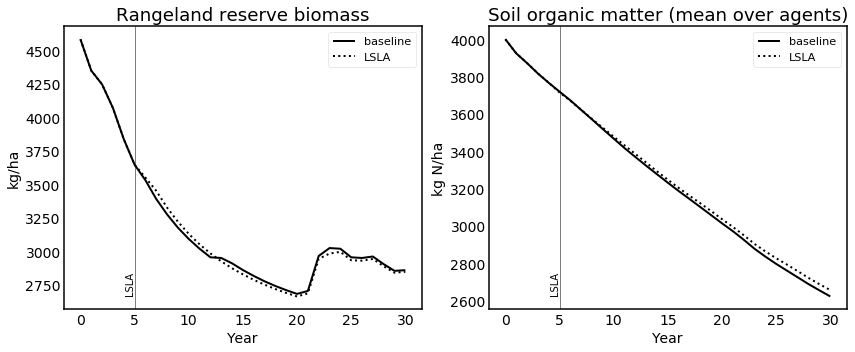

In [7]:
## environmental: rangeland and SOM
fig, axs = plt.subplots(1,2,figsize=(12,5))
lss = {'baseline' : '-', 'LSLA' : ':'}

for scenario, mod in mods.items():
    # rangeland
    axs[0].plot(mod.rangeland.R, label=scenario, ls=lss[scenario], color='k')
    # soil organic matter
    ymin, ymax = np.percentile(mod.land.organic[:,mod.agents.has_land], axis=1, q=[5,95])
    xs = np.arange(mod.T+1)
#     axs[1].fill_between(xs, ymin, ymax, label=scenario, color='0.5', alpha=0.5)
    axs[1].plot(np.mean(mod.land.organic[:,mod.agents.has_land], axis=1), label=scenario, ls=lss[scenario], color='k', lw=2)
    
    if scenario == 'LSLA':
        # add text/line
        for ax in axs:
            ax.axvline(mod.lsla.tstart, color='k', lw=0.5)
            trans = transforms.blended_transform_factory(
                                    ax.transData, ax.transAxes)
            ax.text(mod.lsla.tstart, 0.05, 'LSLA', ha='right', va='bottom', rotation=90, transform=trans)

# formatting
for ax in axs:
    ax.grid(False)
    ax.set_xlabel('Year')
    ax.legend()
axs[0].set_title('Rangeland reserve biomass')
axs[0].set_ylabel('kg/ha')
axs[1].set_title('Soil organic matter (mean over agents)')
axs[1].set_ylabel('kg N/ha')

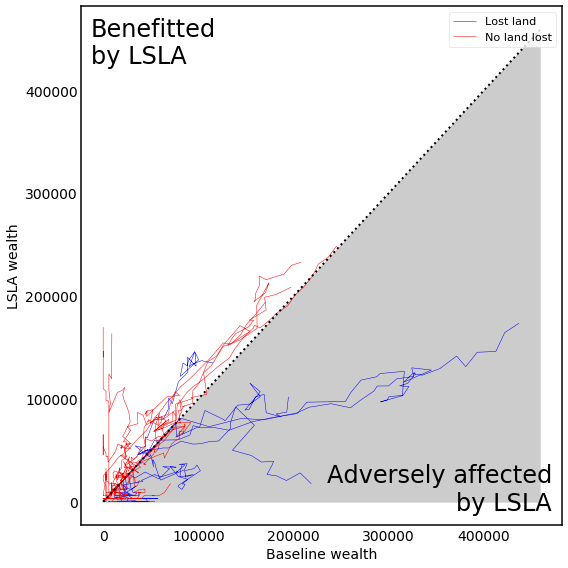

In [10]:
# single agent trajectory
fig, ax = plt.subplots(1,1,figsize=(8,8))
lbls = []
labels = {'b' : 'Lost land', 'r' : 'No land lost'}
for ag in range(mods['baseline'].n_agents):

    base = mods['baseline'].agents.wealth[:,ag]
    lsla = mods['LSLA'].agents.wealth[:,ag]
    color = 'b' if mods['LSLA'].lsla.lost_land[ag] else 'r'
    label = labels[color] if color not in lbls else '_nolegend_'
    ax.plot(base, lsla, color=color, lw=0.5, label=label)
    lbls.append(color)
    
ax.grid(False)
ax.set_xlabel('Baseline wealth')
ax.set_ylabel('LSLA wealth')
mx = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.plot([0,mx], [0,mx], color='k', ls=':')
ax.text(0.98, 0.02, 'Adversely affected\nby LSLA', transform=ax.transAxes, ha='right', va='bottom', fontsize=24)
ax.text(0.02, 0.98, 'Benefitted\nby LSLA', transform=ax.transAxes, ha='left', va='top', fontsize=24)
ax.fill_between([0,mx],[0,mx],[0,0], color='0.5',alpha=0.4)
ax.legend(loc='upper right')

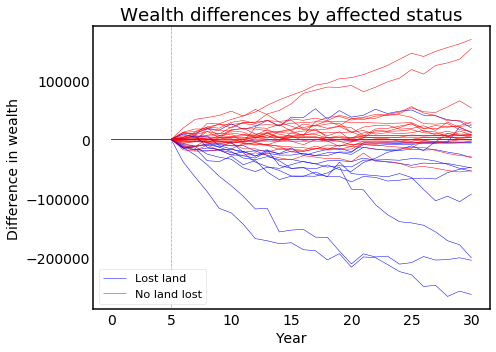

In [15]:
# single agent trajectory
fig, ax = plt.subplots(1,1,figsize=(7,5))
lbls = []
labels = {'b' : 'Lost land', 'r' : 'No land lost'}
for ag in range(mods['baseline'].n_agents):

    base = mods['baseline'].agents.wealth[:,ag]
    lsla = mods['LSLA'].agents.wealth[:,ag]
    color = 'b' if mods['LSLA'].lsla.lost_land[ag] else 'r'
    label = labels[color] if color not in lbls else '_nolegend_'
    ax.plot(lsla-base, color=color, lw=0.5, label=label)
    lbls.append(color)
    
ax.grid(False)
ax.set_xlabel('Year')
ax.set_ylabel('Difference in wealth')
ax.set_title('Wealth differences by affected status')
# mx = max(ax.get_xlim()[1], ax.get_ylim()[1])
# ax.plot([0,mx], [0,mx], color='k', ls=':')
# ax.text(0.98, 0.02, 'Adversely affected\nby LSLA', transform=ax.transAxes, ha='right', va='bottom', fontsize=24)
# ax.text(0.02, 0.98, 'Benefitted\nby LSLA', transform=ax.transAxes, ha='left', va='top', fontsize=24)
# ax.fill_between([0,mx],[0,mx],[0,0], color='0.5',alpha=0.4)
ax.legend(loc='lower left')
ax.axvline(mods['LSLA'].lsla.tstart, color='k', ls=':', lw=0.5)

Text(0.5, 1.0, 'No land lost')

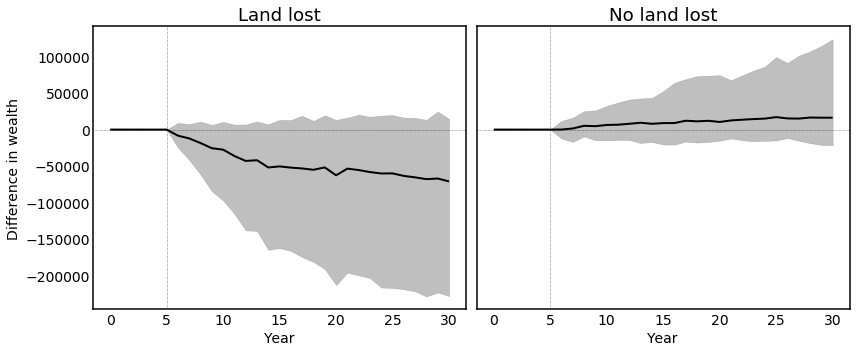

In [21]:
# single agent trajectory
fig, axs = plt.subplots(1,2,figsize=(12,5), sharey=True)
lbls = []
labels = {'b' : 'Lost land', 'r' : 'No land lost'}
T = mods['baseline'].T

# land lost
base_lost = mods['baseline'].agents.wealth[:,mods['LSLA'].lsla.lost_land]
lsla_lost = mods['LSLA'].agents.wealth[:,mods['LSLA'].lsla.lost_land]
lost_diff = lsla_lost - base_lost

axs[0].plot(np.mean(lost_diff, axis=1), color='k', lw=2)
ymn, ymx = np.percentile(lost_diff, q=[5,95], axis=1)
axs[0].fill_between(np.arange(0,T+1), ymn, ymx, color='0.5', alpha=0.5)

# no land lost
base = mods['baseline'].agents.wealth[:,~mods['LSLA'].lsla.lost_land]
lsla = mods['LSLA'].agents.wealth[:,~mods['LSLA'].lsla.lost_land]
no_lost_diff = lsla - base

axs[1].plot(np.mean(no_lost_diff, axis=1), color='k', lw=2)
ymn, ymx = np.percentile(no_lost_diff, q=[5,95], axis=1)
axs[1].fill_between(np.arange(0,T+1), ymn, ymx, color='0.5', alpha=0.5)

for ax in axs:
    ax.grid(False)
    ax.set_xlabel('Year')
    ax.axvline(mods['LSLA'].lsla.tstart, color='k', ls=':', lw=0.5)
    ax.axhline(0, color='k', ls=':', lw=0.5)
axs[0].set_ylabel('Difference in wealth')
axs[0].set_title('Land lost')
axs[1].set_title('No land lost')

Text(0.5, 1.0, 'No land lost')

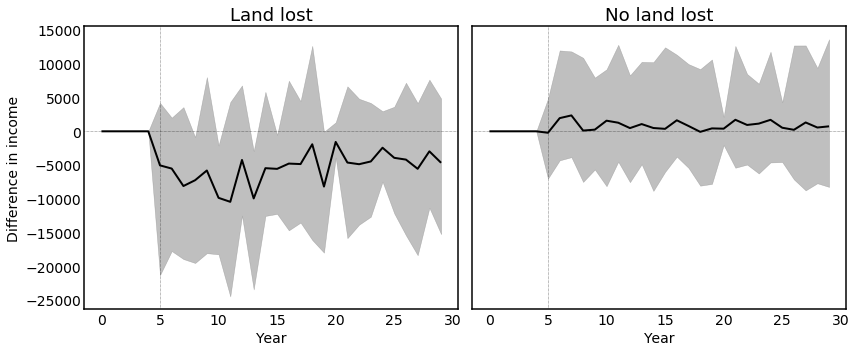

In [24]:
# single agent trajectory
fig, axs = plt.subplots(1,2,figsize=(12,5), sharey=True)
lbls = []
labels = {'b' : 'Lost land', 'r' : 'No land lost'}
T = mods['baseline'].T

# land lost
base_lost = mods['baseline'].agents.income[:,mods['LSLA'].lsla.lost_land]
lsla_lost = mods['LSLA'].agents.income[:,mods['LSLA'].lsla.lost_land]
lost_diff = lsla_lost - base_lost

axs[0].plot(np.mean(lost_diff, axis=1), color='k', lw=2)
ymn, ymx = np.percentile(lost_diff, q=[5,95], axis=1)
axs[0].fill_between(np.arange(0,T), ymn, ymx, color='0.5', alpha=0.5)

# no land lost
base = mods['baseline'].agents.income[:,~mods['LSLA'].lsla.lost_land]
lsla = mods['LSLA'].agents.income[:,~mods['LSLA'].lsla.lost_land]
no_lost_diff = lsla - base

axs[1].plot(np.mean(no_lost_diff, axis=1), color='k', lw=2)
ymn, ymx = np.percentile(no_lost_diff, q=[5,95], axis=1)
axs[1].fill_between(np.arange(0,T), ymn, ymx, color='0.5', alpha=0.5)

for ax in axs:
    ax.grid(False)
    ax.set_xlabel('Year')
    ax.axvline(mods['LSLA'].lsla.tstart, color='k', ls=':', lw=0.5)
    ax.axhline(0, color='k', ls=':', lw=0.5)
axs[0].set_ylabel('Difference in income')
axs[0].set_title('Land lost')
axs[1].set_title('No land lost')

Text(0.5, 0, 'Baseline mean wealth')

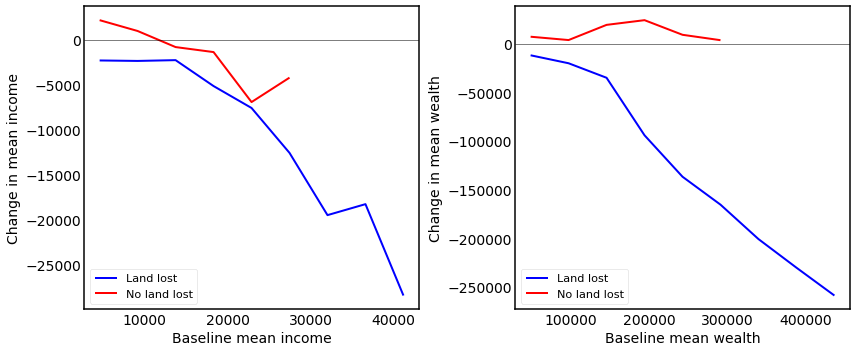

In [48]:
# equity of effect
fig, axs = plt.subplots(1,2, figsize=(12,5))

#### INCOME ####
# land lost
base_lost = mods['baseline'].agents.income[:,mods['LSLA'].lsla.lost_land]
lsla_lost = mods['LSLA'].agents.income[:,mods['LSLA'].lsla.lost_land]
lost_diff = lsla_lost - base_lost
# no land lost
base = mods['baseline'].agents.income[:,~mods['LSLA'].lsla.lost_land]
lsla = mods['LSLA'].agents.income[:,~mods['LSLA'].lsla.lost_land]
no_lost_diff = lsla - base

bins = np.linspace(0, max(base_lost.max(), base.max()), 10)
yvals_lost = []
yvals_no_lost = []
for bi, val in enumerate(bins):
    if bi==0:
        continue
    in_lost = (base_lost > bins[bi-1]) * (base_lost <= bins[bi])
    yvals_lost.append(np.mean(lost_diff[in_lost]))
    in_no_lost = (base > bins[bi-1]) * (base <= bins[bi])
    yvals_no_lost.append(np.mean(no_lost_diff[in_no_lost]))
    
axs[0].plot(bins[1:], yvals_lost, label='Land lost')
axs[0].plot(bins[1:], yvals_no_lost, label='No land lost')
axs[0].legend()
axs[0].axhline(0, color='k', lw=0.5)
axs[0].grid(False)
axs[0].set_ylabel('Change in mean income')
axs[0].set_xlabel('Baseline mean income')


#### WEALTH ####
# land lost
base_lost = mods['baseline'].agents.wealth[:,mods['LSLA'].lsla.lost_land]
lsla_lost = mods['LSLA'].agents.wealth[:,mods['LSLA'].lsla.lost_land]
lost_diff = lsla_lost - base_lost
# no land lost
base = mods['baseline'].agents.wealth[:,~mods['LSLA'].lsla.lost_land]
lsla = mods['LSLA'].agents.wealth[:,~mods['LSLA'].lsla.lost_land]
no_lost_diff = lsla - base

bins = np.linspace(0, max(base_lost.max(), base.max()), 10)
yvals_lost = []
yvals_no_lost = []
for bi, val in enumerate(bins):
    if bi==0:
        continue
    in_lost = (base_lost > bins[bi-1]) * (base_lost <= bins[bi])
    yvals_lost.append(np.mean(lost_diff[in_lost]))
    in_no_lost = (base > bins[bi-1]) * (base <= bins[bi])
    yvals_no_lost.append(np.mean(no_lost_diff[in_no_lost]))
    
axs[1].plot(bins[1:], yvals_lost, label='Land lost')
axs[1].plot(bins[1:], yvals_no_lost, label='No land lost')
axs[1].legend()
axs[1].axhline(0, color='k', lw=0.5)
axs[1].grid(False)
axs[1].set_ylabel('Change in mean wealth')
axs[1].set_xlabel('Baseline mean wealth')

In [39]:
yvals_lost

[370.98387096774195,
 4566.15,
 8959.68085106383,
 10611.746666666666,
 12925.560975609756,
 12300.105263157895,
 9722.42857142857,
 16308.0,
 12258.666666666666]